In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from pandas.core.dtypes.common import is_numeric_dtype

In [2]:
DATA_FOLDER = 'dataset'
COMPLETE_DATA = os.path.join(DATA_FOLDER, 'complete_dataset.csv')
# intermediate -> dataset before the elimination of correlated features
INTERMEDIATE_DATA = os.path.join(DATA_FOLDER, 'intermediate_dataset.csv')
DATASET = os.path.join(DATA_FOLDER, 'preprocessed_df.csv')

In [3]:
df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

## Outliers using KNN

In [4]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
import networkx as nx

n_neighbors = 20
normalized_df = (df[numerical_attr_list] - df[numerical_attr_list].min()) / (df[numerical_attr_list].max() - df[numerical_attr_list].min())
G = kneighbors_graph(normalized_df.values, n_neighbors=n_neighbors, mode='distance', p=np.inf)
G = nx.DiGraph(G)
dictator = nx.to_dict_of_dicts(G);

In [5]:
score = np.zeros(len(normalized_df))
for element in dictator.keys():
    mean_dist = 0
    for child in dictator[element].keys():
        mean_dist += dictator[element][child]["weight"] / n_neighbors
    score[element] = mean_dist

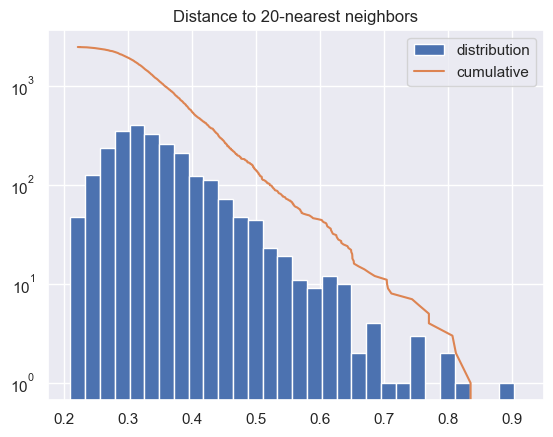

In [6]:
plt.hist(score, bins=30, align="left", label="distribution")
plt.plot(np.flip(np.sort(score)), np.linspace(0, len(df), len(df)), label="cumulative")
plt.yscale('log')
plt.title(f'Distance to {n_neighbors}-nearest neighbors')
plt.legend()
plt.show()

In [7]:
from sklearn.manifold import Isomap

reducer = Isomap(n_neighbors=n_neighbors, p=10)
embedding = reducer.fit_transform(normalized_df)
print(embedding.shape)

(2452, 2)


71


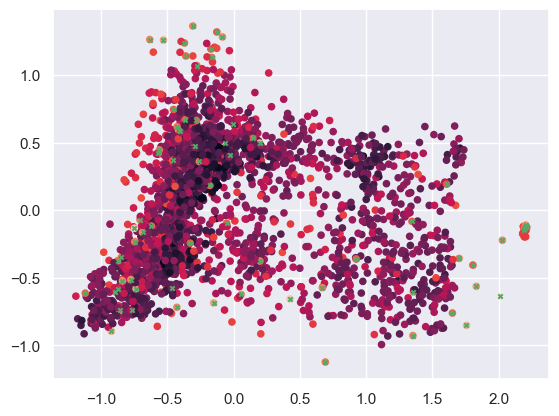

In [8]:
plt.scatter(*embedding.T, c=np.log10(score), s=20)
cutted = embedding[score > 0.55]
print(len(cutted))
plt.scatter(*cutted.T, marker="x", color="g", s=10)
plt.show()

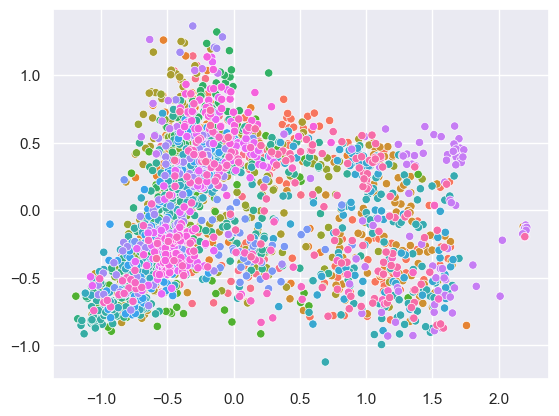

In [9]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['actor'], legend=False)
plt.show()

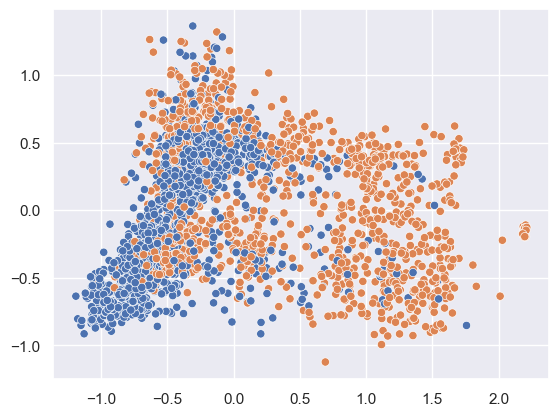

In [10]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['sex'], legend=False)
plt.show()

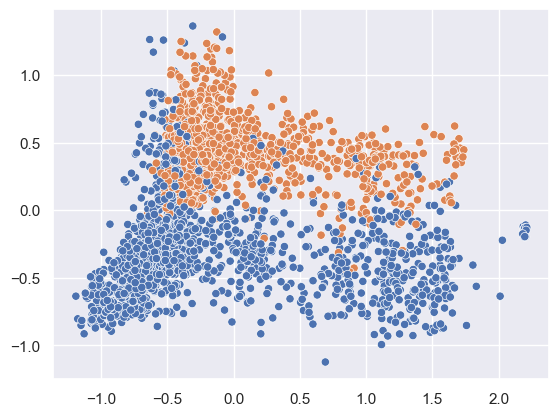

In [11]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df["vocal_channel"], legend=False)
plt.show()

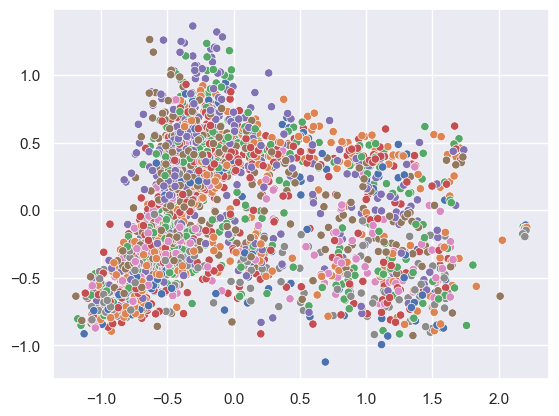

In [12]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df["emotion"], legend=False)
plt.show()

## Isolation forest

In [13]:
from sklearn.ensemble import IsolationForest

isfo = IsolationForest(max_samples=200)
outliers = isfo.fit_predict(normalized_df.values)

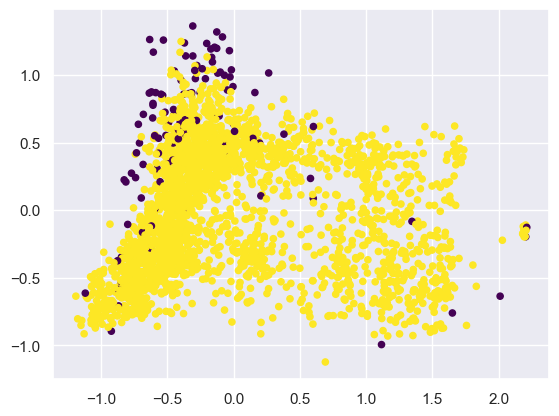

In [14]:
plt.scatter(*embedding.T, c=outliers, s=20, cmap='viridis')
plt.show()

In [15]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 113, 2339]))

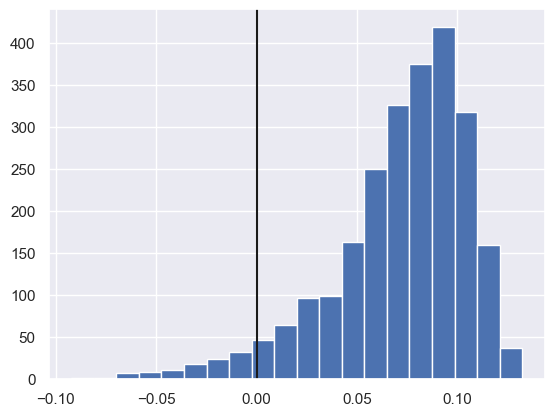

In [16]:
plt.hist(isfo.decision_function(normalized_df.values), bins=20)
plt.axvline(np.min(isfo.decision_function(normalized_df.values)[np.where(outliers==1)]), c='k')
plt.show()

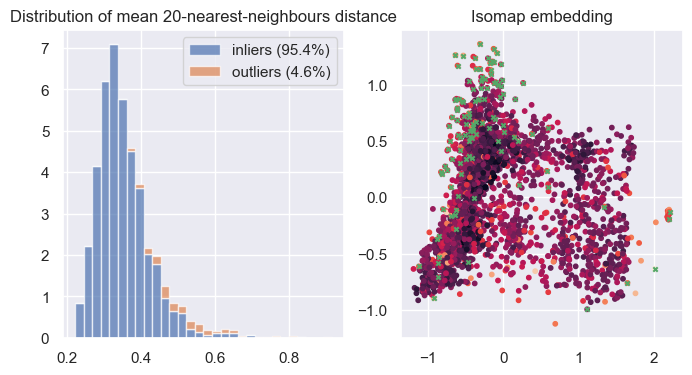

In [17]:
fig, (axhist, axscat) = plt.subplots(1, 2, figsize=(8,4))

axhist.set_title(f"Distribution of mean {n_neighbors}-nearest-neighbours distance")
axscat.set_title("Isomap embedding")

axscat.scatter(*embedding.T, c=np.log10(score), s=10)
axscat.scatter(*embedding[outliers == -1].T, marker="x", color="g", s=10)

labels = [
    f"inliers ({np.sum(outliers==1)/len(df)*100:.1f}%)",
    f"outliers ({np.sum(outliers==-1)/len(df)*100:.1f}%)"
]
axhist.hist([score[outliers == 1], score[outliers == -1]], bins=30,label=labels, density=True,stacked=True, alpha=0.7)

axhist.legend();